## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2019.

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/DL-Assignment 3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/DL-Assignment 3


# Task 2: Neural Machine Translation:



The task of neural machine translation(NMT) implements multi-layer Recurrent Neural Network (RNN, LSTM, and GRU) for translating from one language to another. 

Here the task is to train a neural machine translation RNN in tensorflow to translate from french to english

In [0]:
import os
import pickle
import copy
import numpy as np
import time
import tensorflow as tf
from utils.nmt import *
from matplotlib import pyplot as plt

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of utils.nmt failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/gdrive/My Drive/DL-Assignment 3/utils/nmt.py", line 420
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, temp), grad_clip)
                                                                         ^
TabError: inconsistent use of tabs and spaces in indentation
]


## Part 1: Setup 

Here will will preprocess the data necessary for the task

In [0]:
source_path = 'nmt_data/fr.txt'
target_path = 'nmt_data/en.txt'
source_text = load_data(source_path)
target_text = load_data(target_path)

Let us have a look at some sample translation to get an inderstanding of the task.

In [0]:
english_sentences = target_text.split('\n')
french_sentences = source_text.split('\n')

#Fetch the first five translations
sents = list(zip(french_sentences,english_sentences))[0:5]
print(sents)
side_by_side_sentences = list(zip(english_sentences, french_sentences))[0:5]
print("Sample translations: \n")
for index, sentence in enumerate(side_by_side_sentences):
    en_sent,fr_sent  = sentence
    print('sentence number {}'.format(index+1))
    print('\tfr: {}'.format(fr_sent))
    print('\ten: {}'.format(en_sent))
    print()

[("new jersey est parfois calme pendant l' automne , et il est neigeux en avril .", 'new jersey is sometimes quiet during autumn , and it is snowy in april .'), ('les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .', 'the united states is usually chilly during july , and it is usually freezing in november .'), ('california est généralement calme en mars , et il est généralement chaud en juin .', 'california is usually quiet during march , and it is usually hot in june .'), ('les états-unis est parfois légère en juin , et il fait froid en septembre .', 'the united states is sometimes mild during june , and it is cold in september .'), ('votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme .', 'your least liked fruit is the grape , but my least liked is the apple .')]
Sample translations: 

sentence number 1
	fr: new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
	en: new jersey is sometimes quiet durin

Now that we have the translation data. We will do the following preprocessing steps

1. create lookup tables
    - here we create a unique mapping between each distinct word and it's word id
2. text to word ids
    - we convert all the text sentences to word id replaced sentences

In [0]:
#please look at utils/nmt.py for the full function
preprocess_and_save_data(source_path, target_path, text_to_ids)

In [0]:
#load the data after it has been preprocessed
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = load_preprocess()
print(source_int_text[0], source_vocab_to_int)#, target_int_text, source_vocab_to_int, target_vocab_to_int)

[297, 224, 128, 106, 229, 239, 245, 100, 223, 176, 301, 128, 347, 298, 49, 145] {'<PAD>': 0, '<EOS>': 1, '<UNK>': 2, '<GO>': 3, 'as-tu': 4, 'pleut': 5, 'bleu': 6, 'frais': 7, 'va': 8, 'était': 9, 'du': 10, 'novembre': 11, 'votre': 12, 'aimé': 13, "n'êtes": 14, "d'": 15, 'visiter': 16, 'à': 17, 'lui': 18, 'vos': 19, 'états-unis': 20, 'citron': 21, 'juin': 22, 'chinois': 23, 'requins': 24, 'pomme': 25, 'dernier': 26, 'intention': 27, '-ce': 28, 'comment': 29, 'notre': 30, 'êtes-vous': 31, 'mois': 32, 'poire': 33, 'aller': 34, 'envisagent': 35, 'allée': 36, 'cette': 37, 'clémentes': 38, "n'a": 39, 'lac': 40, '?': 41, 'enneigée': 42, 'camion': 43, "l'orange": 44, 'pas': 45, 'peu': 46, 'raisins': 47, 'traduis': 48, 'avril': 49, 'france': 50, 'où': 51, 'aiment': 52, 'pousse': 53, 'beau': 54, 'allez': 55, 'faire': 56, 'pamplemousses': 57, 'oranges': 58, 'chaud': 59, 'mai': 60, 'déteste': 61, 'glaciales': 62, 'sont': 63, "l'épicerie": 64, 'aimons': 65, 'son': 66, 'animal': 67, 'trouvé': 68, 'c

## Part 2: Create the RNN model

![img](img/seq2seq.jpg)

The seq2seq learning model in this assignment is based on this paper: https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf

The translation model can be visualized in the simplest way as shown above

Some useful functions to look up for seq to seq translation task are



#### Encoder
- [`tf.contrib.layers.embed_sequence`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence)

RNN layers
- [`tf.contrib.rnn.LSTMCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/LSTMCell)
  - creates an LSTM cell
- [`tf.contrib.rnn.GRUCell`](https://www.tensorflow.org/api_docs/python/tf/nn/rnn_cell/GRUCell)
  - creates an LSTM cell
- [`tf.contrib.rnn.DropoutWrapper`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/DropoutWrapper)
  - wraps a cell with keep probability value 
- [`tf.contrib.rnn.MultiRNNCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/MultiRNNCell)
  - stacks multiple RNN (type) cells
  
Encoding model
- [`tf.nn.dynamic_rnn`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn)
  - put Embedding layer and RNN layer(s) all together

#### Decoder training
- [`tf.contrib.seq2seq.TrainingHelper`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/TrainingHelper)
  - TrainingHelper is where we pass the embeded input. As the name indicates, this is only a helper instance. This instance should be delivered to the BasicDecoder, which is the actual process of building the decoder model.
- [`tf.contrib.seq2seq.BasicDecoder`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BasicDecoder)
  - BasicDecoder builds the decoder model. It means it connects the RNN layer(s) on the decoder side and the input prepared by TrainingHelper.
- [`tf.contrib.seq2seq.dynamic_decode`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_decode)
  - dynamic_decode unrolls the decoder model so that actual prediction can be retrieved by BasicDecoder for each time steps.
  
#### Decoder inference
- [`tf.contrib.seq2seq.GreedyEmbeddingHelper`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/GreedyEmbeddingHelper)
  - GreedyEmbeddingHelper dynamically takes the output of the current step and give it to the next time step's input. In order to embed the each input result dynamically, embedding parameter(just bunch of weight values) should be provided. Along with it, GreedyEmbeddingHelper asks to give the `start_of_sequence_id` for the same amount as the batch size and `end_of_sequence_id`.
- [`tf.contrib.seq2seq.BasicDecoder`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BasicDecoder)
  - same as described in the training process section
- [`tf.contrib.seq2seq.dynamic_decode`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_decode)
  - same as described in the training process section

We also use 4 special tokens for translation:

    * <PAD>: to pad the sentence so all sentences are of the same length
    * <EOS>: to mark the end of sentence
    * <UNK>: to mark texts which are not in our dictionary
    * <GO>: the first token that is passed to the decoder output

<span style="color:red">__TODO:__</span>: finish the following functions in utils/nmt.py. Refer to the functions above on which functions could be helpful

    * encoding_layer : creates the enncoder part of the seq-seq learning architecture.
    * decoding_layer : creates the decoder part of the seq2seq learning architecture. This function outputs both the output during training and output during inference
    * my_optimizer : implements the optimizer with gradient clipping

Initially we will create a Seq2Seq model using LSTM as the building block. First we will will define all the hyperparameters required. Feel free to play around with them to improve the model performance

In [0]:
# these are preset parameters, you can change them to get better result
display_step = 300

epochs = 13
batch_size = 128

rnn_size = 128
num_layers = 3

encoding_embedding_size = 200
decoding_embedding_size = 200

learning_rate = 0.001
keep_probability = 0.5
grad_clip = 5
cell_type = 'LSTM'
rnn1_loss_history = []

Next we will define the graph for the model.

In [0]:
save_path = 'checkpoints/dev_LSTM'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = load_preprocess()
max_target_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, target_sequence_length, max_target_sequence_length = enc_dec_model_inputs()
    lr, keep_prob = hyperparam_inputs()
    
    train_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                   targets,
                                                   keep_prob,
                                                   batch_size,
                                                   target_sequence_length,
                                                   max_target_sequence_length,
                                                   len(source_vocab_to_int),
                                                   len(target_vocab_to_int),
                                                   encoding_embedding_size,
                                                   decoding_embedding_size,
                                                   rnn_size,
                                                   num_layers,
                                                   target_vocab_to_int,
                                                   cell_type)
    
    training_logits = tf.identity(train_logits.rnn_output, name='logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')
    # - Returns a mask tensor representing the first N positions of each cell.
    masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function - weighted softmax cross entropy
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        train_op = my_optimizer(cost,grad_clip,lr)



Once the graph has been defined we will train the seq2seq model to perform the translations

In [0]:


# Split data to training and validation sets
train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]
valid_source = source_int_text[:batch_size]
valid_target = target_int_text[:batch_size]
(valid_sources_batch, valid_targets_batch, valid_sources_lengths, valid_targets_lengths ) = next(get_batches(valid_source,
                                                                                                             valid_target,
                                                                                                             batch_size,
                                                                                                             source_vocab_to_int['<PAD>'],
                                                                                                             target_vocab_to_int['<PAD>']))                                                                                                  

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(epochs):
        print(epoch_i)
        for batch_i, (source_batch, target_batch, sources_lengths, targets_lengths) in enumerate(
                get_batches(train_source, train_target, batch_size,
                            source_vocab_to_int['<PAD>'],
                            target_vocab_to_int['<PAD>'])):
            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 target_sequence_length: targets_lengths,
                 keep_prob: keep_probability})
            rnn1_loss_history.append(loss)
            

            if batch_i % display_step == 0 and batch_i > 0:
                batch_train_logits = sess.run(
                    inference_logits,
                    {input_data: source_batch,
                     target_sequence_length: targets_lengths,
                     keep_prob: 1.0})

                batch_valid_logits = sess.run(
                    inference_logits,
                    {input_data: valid_sources_batch,
                     target_sequence_length: valid_targets_lengths,
                     keep_prob: 1.0})

                train_acc = get_accuracy(target_batch, batch_train_logits)
                valid_acc = get_accuracy(valid_targets_batch, batch_valid_logits)

                print('Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.4f}, Validation Accuracy: {:>6.4f}, Loss: {:>6.4f}'
                      .format(epoch_i, batch_i, len(source_int_text) // batch_size, train_acc, valid_acc, loss))

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    print('Model Trained and Saved')

0
Epoch   0 Batch  300/1077 - Train Accuracy: 0.6285, Validation Accuracy: 0.6363, Loss: 1.5075
Epoch   0 Batch  600/1077 - Train Accuracy: 0.6602, Validation Accuracy: 0.6450, Loss: 1.0458
Epoch   0 Batch  900/1077 - Train Accuracy: 0.6858, Validation Accuracy: 0.6992, Loss: 0.8574
1
Epoch   1 Batch  300/1077 - Train Accuracy: 0.7405, Validation Accuracy: 0.7378, Loss: 0.7095
Epoch   1 Batch  600/1077 - Train Accuracy: 0.7483, Validation Accuracy: 0.7526, Loss: 0.6511
Epoch   1 Batch  900/1077 - Train Accuracy: 0.7574, Validation Accuracy: 0.7578, Loss: 0.6237
2
Epoch   2 Batch  300/1077 - Train Accuracy: 0.7856, Validation Accuracy: 0.7695, Loss: 0.5636
Epoch   2 Batch  600/1077 - Train Accuracy: 0.7869, Validation Accuracy: 0.7873, Loss: 0.5048
Epoch   2 Batch  900/1077 - Train Accuracy: 0.7908, Validation Accuracy: 0.7934, Loss: 0.5008
3
Epoch   3 Batch  300/1077 - Train Accuracy: 0.8099, Validation Accuracy: 0.8043, Loss: 0.4288
Epoch   3 Batch  600/1077 - Train Accuracy: 0.8242, 

In [0]:
# Save parameters for checkpoint
save_params(save_path,cell_type)

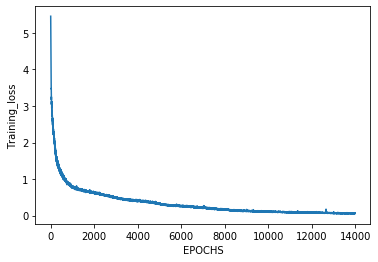

In [0]:
# plot loss history
loss_data = rnn1_loss_history
from matplotlib import pyplot as plt
plt.plot(np.arange(len(loss_data)),loss_data)
plt.ylabel('Training_loss')
plt.xlabel('EPOCHS')
plt.show()

### Change another type of RNN cell
We are using LSTM cell as the original work, but GRU cell is getting more popular today, let's chage the cell type layer to GRU cell and see how it performs. Your parameters should be the same as above to compare the two units

In [0]:
# these are preset parameters, you can change them to get better result
display_step = 300

epochs = 13
batch_size = 128

rnn_size = 128
num_layers = 3

encoding_embedding_size = 200
decoding_embedding_size = 200

learning_rate = 0.001
keep_probability = 0.5
grad_clip = 5
cell_type = 'GRU' #THIS IS CHANGED TO GRU
rnn2_loss_history = []

In [0]:
save_path = 'checkpoints/dev_GRU'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = load_preprocess()
max_target_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, target_sequence_length, max_target_sequence_length = enc_dec_model_inputs()
    lr, keep_prob = hyperparam_inputs()
    
    train_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                   targets,
                                                   keep_prob,
                                                   batch_size,
                                                   target_sequence_length,
                                                   max_target_sequence_length,
                                                   len(source_vocab_to_int),
                                                   len(target_vocab_to_int),
                                                   encoding_embedding_size,
                                                   decoding_embedding_size,
                                                   rnn_size,
                                                   num_layers,
                                                   target_vocab_to_int,
                                                   cell_type)
    
    training_logits = tf.identity(train_logits.rnn_output, name='logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')

    # https://www.tensorflow.org/api_docs/python/tf/sequence_mask
    # - Returns a mask tensor representing the first N positions of each cell.
    masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function - weighted softmax cross entropy
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        train_op = my_optimizer(cost,grad_clip,lr)



Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:


# Split data to training and validation sets
train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]
valid_source = source_int_text[:batch_size]
valid_target = target_int_text[:batch_size]
(valid_sources_batch, valid_targets_batch, valid_sources_lengths, valid_targets_lengths ) = next(get_batches(valid_source,
                                                                                                             valid_target,
                                                                                                             batch_size,
                                                                                                             source_vocab_to_int['<PAD>'],
                                                                                                             target_vocab_to_int['<PAD>']))                                                                                                  
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(epochs):
        for batch_i, (source_batch, target_batch, sources_lengths, targets_lengths) in enumerate(
                get_batches(train_source, train_target, batch_size,
                            source_vocab_to_int['<PAD>'],
                            target_vocab_to_int['<PAD>'])):

            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 target_sequence_length: targets_lengths,
                 keep_prob: keep_probability})
            rnn2_loss_history.append(loss)


            if batch_i % display_step == 0 and batch_i > 0:
                batch_train_logits = sess.run(
                    inference_logits,
                    {input_data: source_batch,
                     target_sequence_length: targets_lengths,
                     keep_prob: 1.0})

                batch_valid_logits = sess.run(
                    inference_logits,
                    {input_data: valid_sources_batch,
                     target_sequence_length: valid_targets_lengths,
                     keep_prob: 1.0})

                train_acc = get_accuracy(target_batch, batch_train_logits)
                valid_acc = get_accuracy(valid_targets_batch, batch_valid_logits)

                print('Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.4f}, Validation Accuracy: {:>6.4f}, Loss: {:>6.4f}'
                      .format(epoch_i, batch_i, len(source_int_text) // batch_size, train_acc, valid_acc, loss))

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    print('Model Trained and Saved')

Epoch   0 Batch  300/1077 - Train Accuracy: 0.5425, Validation Accuracy: 0.5312, Loss: 1.4696
Epoch   0 Batch  600/1077 - Train Accuracy: 0.6888, Validation Accuracy: 0.6962, Loss: 1.0733
Epoch   0 Batch  900/1077 - Train Accuracy: 0.7148, Validation Accuracy: 0.7036, Loss: 0.9202
Epoch   1 Batch  300/1077 - Train Accuracy: 0.7513, Validation Accuracy: 0.7274, Loss: 0.7419
Epoch   1 Batch  600/1077 - Train Accuracy: 0.7496, Validation Accuracy: 0.7409, Loss: 0.6849
Epoch   1 Batch  900/1077 - Train Accuracy: 0.7509, Validation Accuracy: 0.7513, Loss: 0.6777
Epoch   2 Batch  300/1077 - Train Accuracy: 0.7617, Validation Accuracy: 0.7535, Loss: 0.6235
Epoch   2 Batch  600/1077 - Train Accuracy: 0.7691, Validation Accuracy: 0.7617, Loss: 0.5891
Epoch   2 Batch  900/1077 - Train Accuracy: 0.7622, Validation Accuracy: 0.7652, Loss: 0.5997
Epoch   3 Batch  300/1077 - Train Accuracy: 0.7847, Validation Accuracy: 0.7739, Loss: 0.5662
Epoch   3 Batch  600/1077 - Train Accuracy: 0.7782, Validati

In [0]:
# Save parameters for checkpoint
save_params(save_path,cell_type)

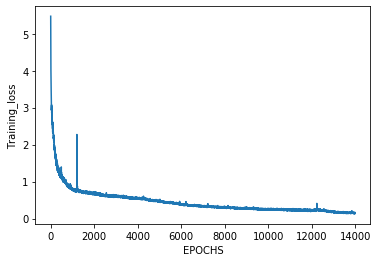

In [0]:
# plot loss history
# plot loss history
loss_data = rnn2_loss_history
from matplotlib import pyplot as plt
plt.plot(np.arange(len(loss_data)),loss_data)
plt.ylabel('Training_loss')
plt.xlabel('EPOCHS')
plt.show()

## Translate
This will translate translate_sentence from French to English

In [0]:
cell_type = "LSTM" #change this to LSTM or GRU to traslate using appropriate model
_, (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab, target_int_to_vocab) = load_preprocess()
load_path = load_params(cell_type)

In [0]:

translate_sentence = side_by_side_sentences[0][1]
correct_translation = side_by_side_sentences[0][0]

translate_sentence = sentence_to_seq(translate_sentence, source_vocab_to_int)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    target_sequence_length = loaded_graph.get_tensor_by_name('target_sequence_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    translate_logits = sess.run(logits, {input_data: [translate_sentence]*batch_size,
                                         target_sequence_length: [len(translate_sentence)*2]*batch_size,
                                         keep_prob: 1.0})[0]

print('Input')
print('  Word Ids:      {}'.format([i for i in translate_sentence]))
print('  French Words: {}'.format([source_int_to_vocab[i] for i in translate_sentence]))

print('\nPrediction')
print('  Word Ids:      {}'.format([i for i in translate_logits]))
print('  English Words: {}'.format(" ".join([target_int_to_vocab[i] for i in translate_logits])))

print('\nCorrect translation')
print('  English Words: {}'.format(correct_translation))

INFO:tensorflow:Restoring parameters from checkpoints/dev_LSTM
Input
  Word Ids:      [297, 224, 128, 106, 229, 239, 245, 100, 223, 176, 301, 128, 347, 298, 49, 145]
  French Words: ['new', 'jersey', 'est', 'parfois', 'calme', 'pendant', "l'", 'automne', ',', 'et', 'il', 'est', 'neigeux', 'en', 'avril', '.']

Prediction
  Word Ids:      [36, 68, 81, 144, 50, 86, 122, 65, 9, 39, 81, 50, 229, 198, 123, 1]
  English Words: new jersey is sometimes snowy during fall , and it is snowy in april . <EOS>

Correct translation
  English Words: new jersey is sometimes quiet during autumn , and it is snowy in april .


#### Compare your result and list pros and cons of using GRU cells compared to LSTM

Answer:
**

PROS:

1) GRU Cells are simpler as compared to LSTM cells

2) GRU Cells are easier to train and less mathematically complicated. 

3) GRUs train faster and with lesser data.

CONS:

1) LSTM can store more data and thus can hold data over long time values

2) Since, there are more werights, we have more control and thus flexibility over the output and data storage of a model in LSTM


Overall, GRUs are new, but are better in terms of computation, and provide almost the same, or better performance as LSTMs
**